In [1]:
%matplotlib inline

Classification, Segmentation = 0, 1
ml_types = ['Classification', 'Segmentation']
batch_sizes = [150, 30]

ml_type = Segmentation

version = '0.5'


batch_size=batch_sizes[ml_type]

epochs=1
learning_rate = (10**(-4))*1.0

training=True
resume_training=True

base='/mnt/z9-slide-storage/VipsML'

weights_path=base + '/weights/Vips{}_{}'.format(ml_types[ml_type], version)


In [2]:

import pyvips as Vips
from models import SmallerVGGNet, SegNet
import VipsML

if ml_type == Segmentation:
    origs=[Vips.Image.new_from_file(base+'/00-orig.tif')]
    masks=[Vips.Image.new_from_file(base+'/00-mask_5.tif')]
elif ml_type == Classification:
    origs=[Vips.Image.new_from_file(base+'/0'+str(n)+'-orig.tif') for n in range(1,4)]
    masks=[Vips.Image.new_from_file(base+'/0'+str(n)+'-mask.tif') for n in range(1,4)]

models = [SmallerVGGNet, SegNet]
CNNModel = models[ml_type]

image_classes = [VipsML.VipsClassificationML, VipsML.VipsSegmentationML]
ImageClass = image_classes[ml_type]

images = [ImageClass(orig,mask) for orig, mask in zip(origs,masks)]

generator=VipsML.VipsGroupML(images, batch_size=batch_size)

model = CNNModel(generator.shape, generator.classes)

Using TensorFlow backend.


ValueError: cannot reshape array of size 5 into shape (63,63,5)

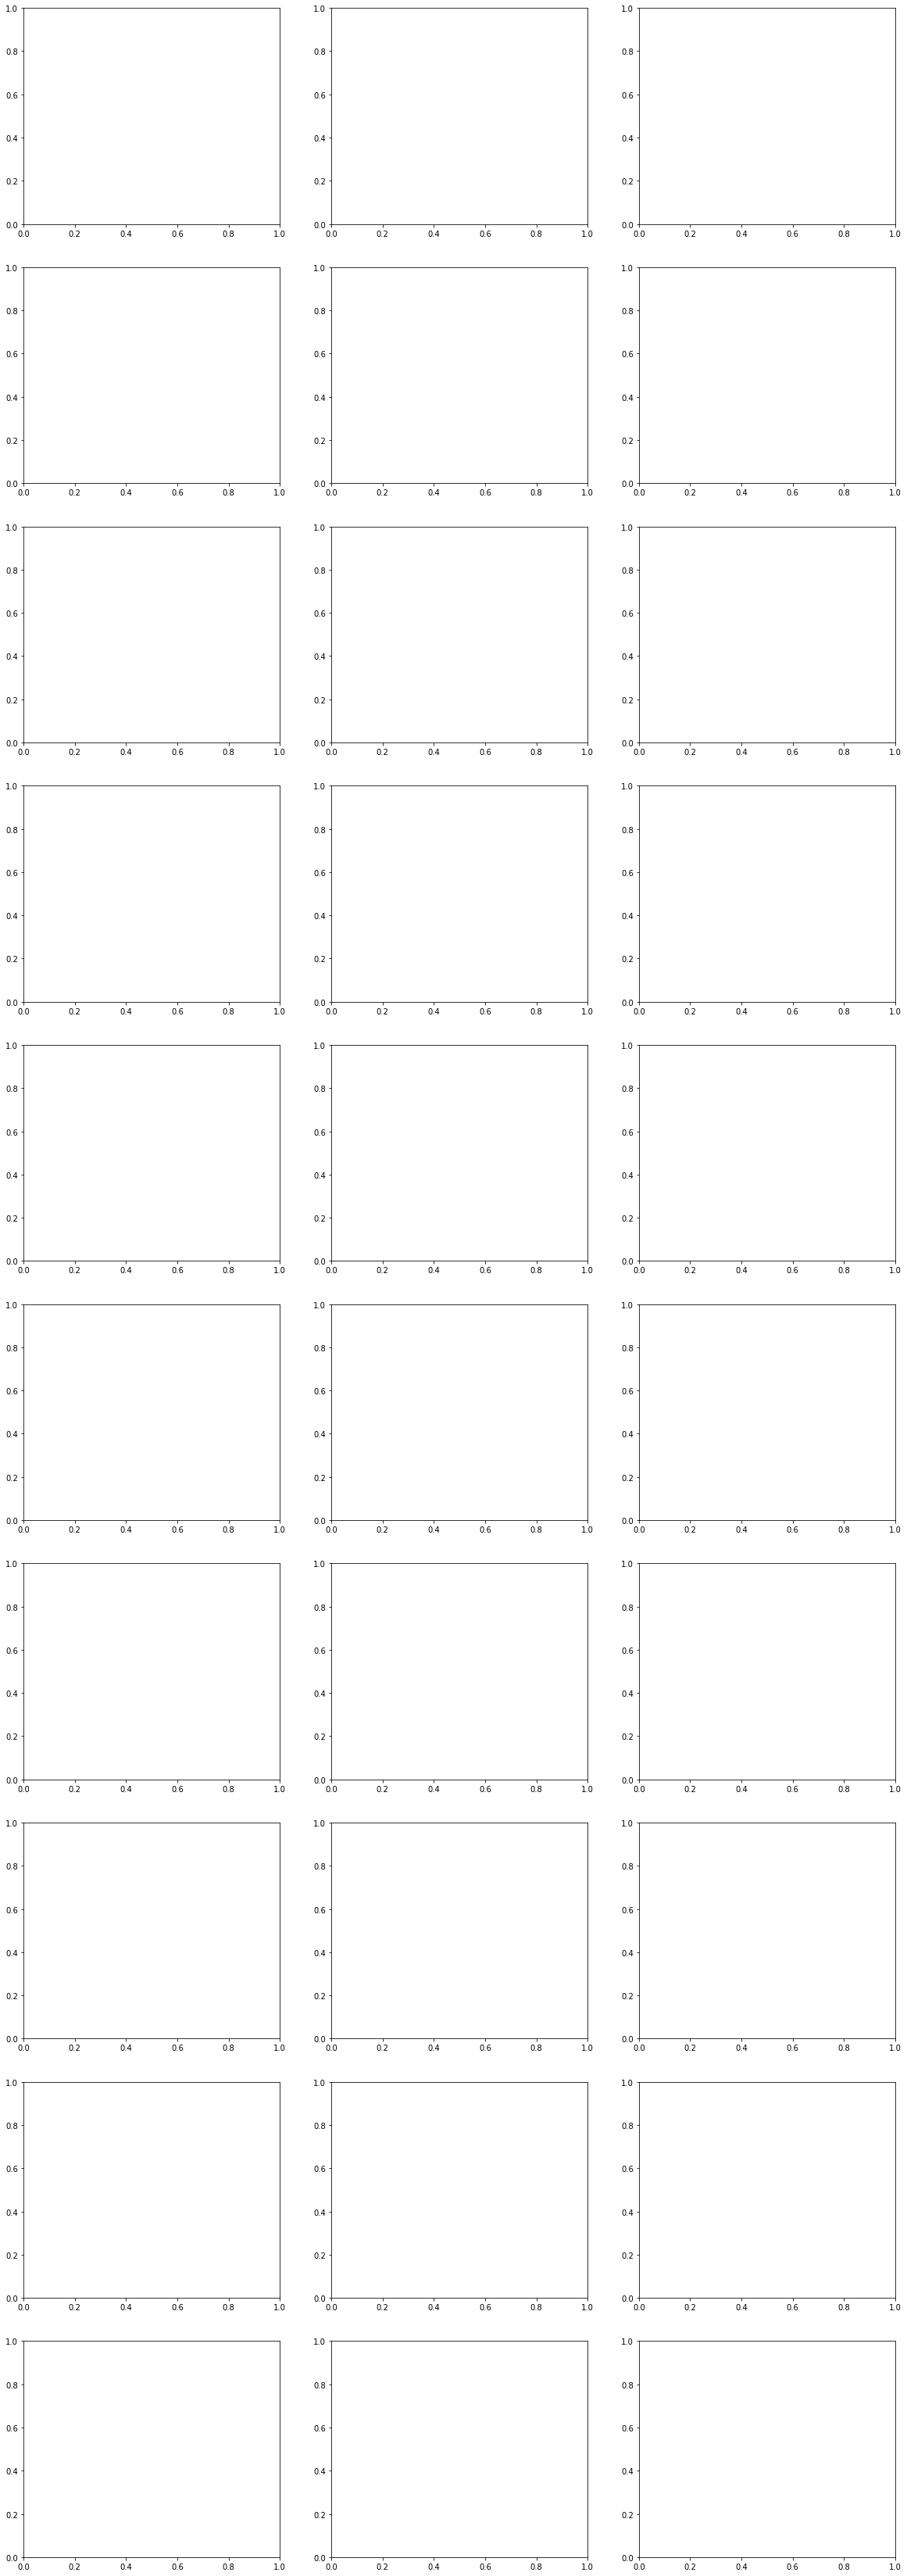

In [153]:
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
import numpy as np
from random import choice, shuffle
import tools

#from importlib import reload
#reload(VipsML)

from keras.optimizers import SGD
opt = SGD(lr=learning_rate, decay=learning_rate / epochs)

if training:    
    model.compile(loss="categorical_crossentropy", optimizer=opt,
        metrics=["categorical_accuracy"])    
    
    if resume_training:
        model.load_weights(weights_path)    

    checkpointer = ModelCheckpoint(filepath=weights_path + "_tmp", verbose=1,save_best_only=True)
    
    trainer, validator = generator.split_generators(0.1)
    
    H = model.fit_generator(trainer,validation_data=validator,epochs=epochs, callbacks=[checkpointer,tools.Previewer(generator,2)])
    
    model.save(weights_path)
else:
    tools.preview_model(model,generator,10,weights_path)

In [3]:

from importlib import reload
#import models
#import VipsML

reload(VipsML)
#reload(models)
whole=Vips.Image.new_from_file(base+'/392.tif')
s2=ImageClass(whole)
model = CNNModel(s2.shape, 5)
model.load_weights(weights_path ) 
#s2=VipsML2.VipsSegmentationML(whole)
im=s2.predict_model(model, batch_size=batch_size)


100%|██████████| 22/22 [00:33<00:00,  1.42s/it]


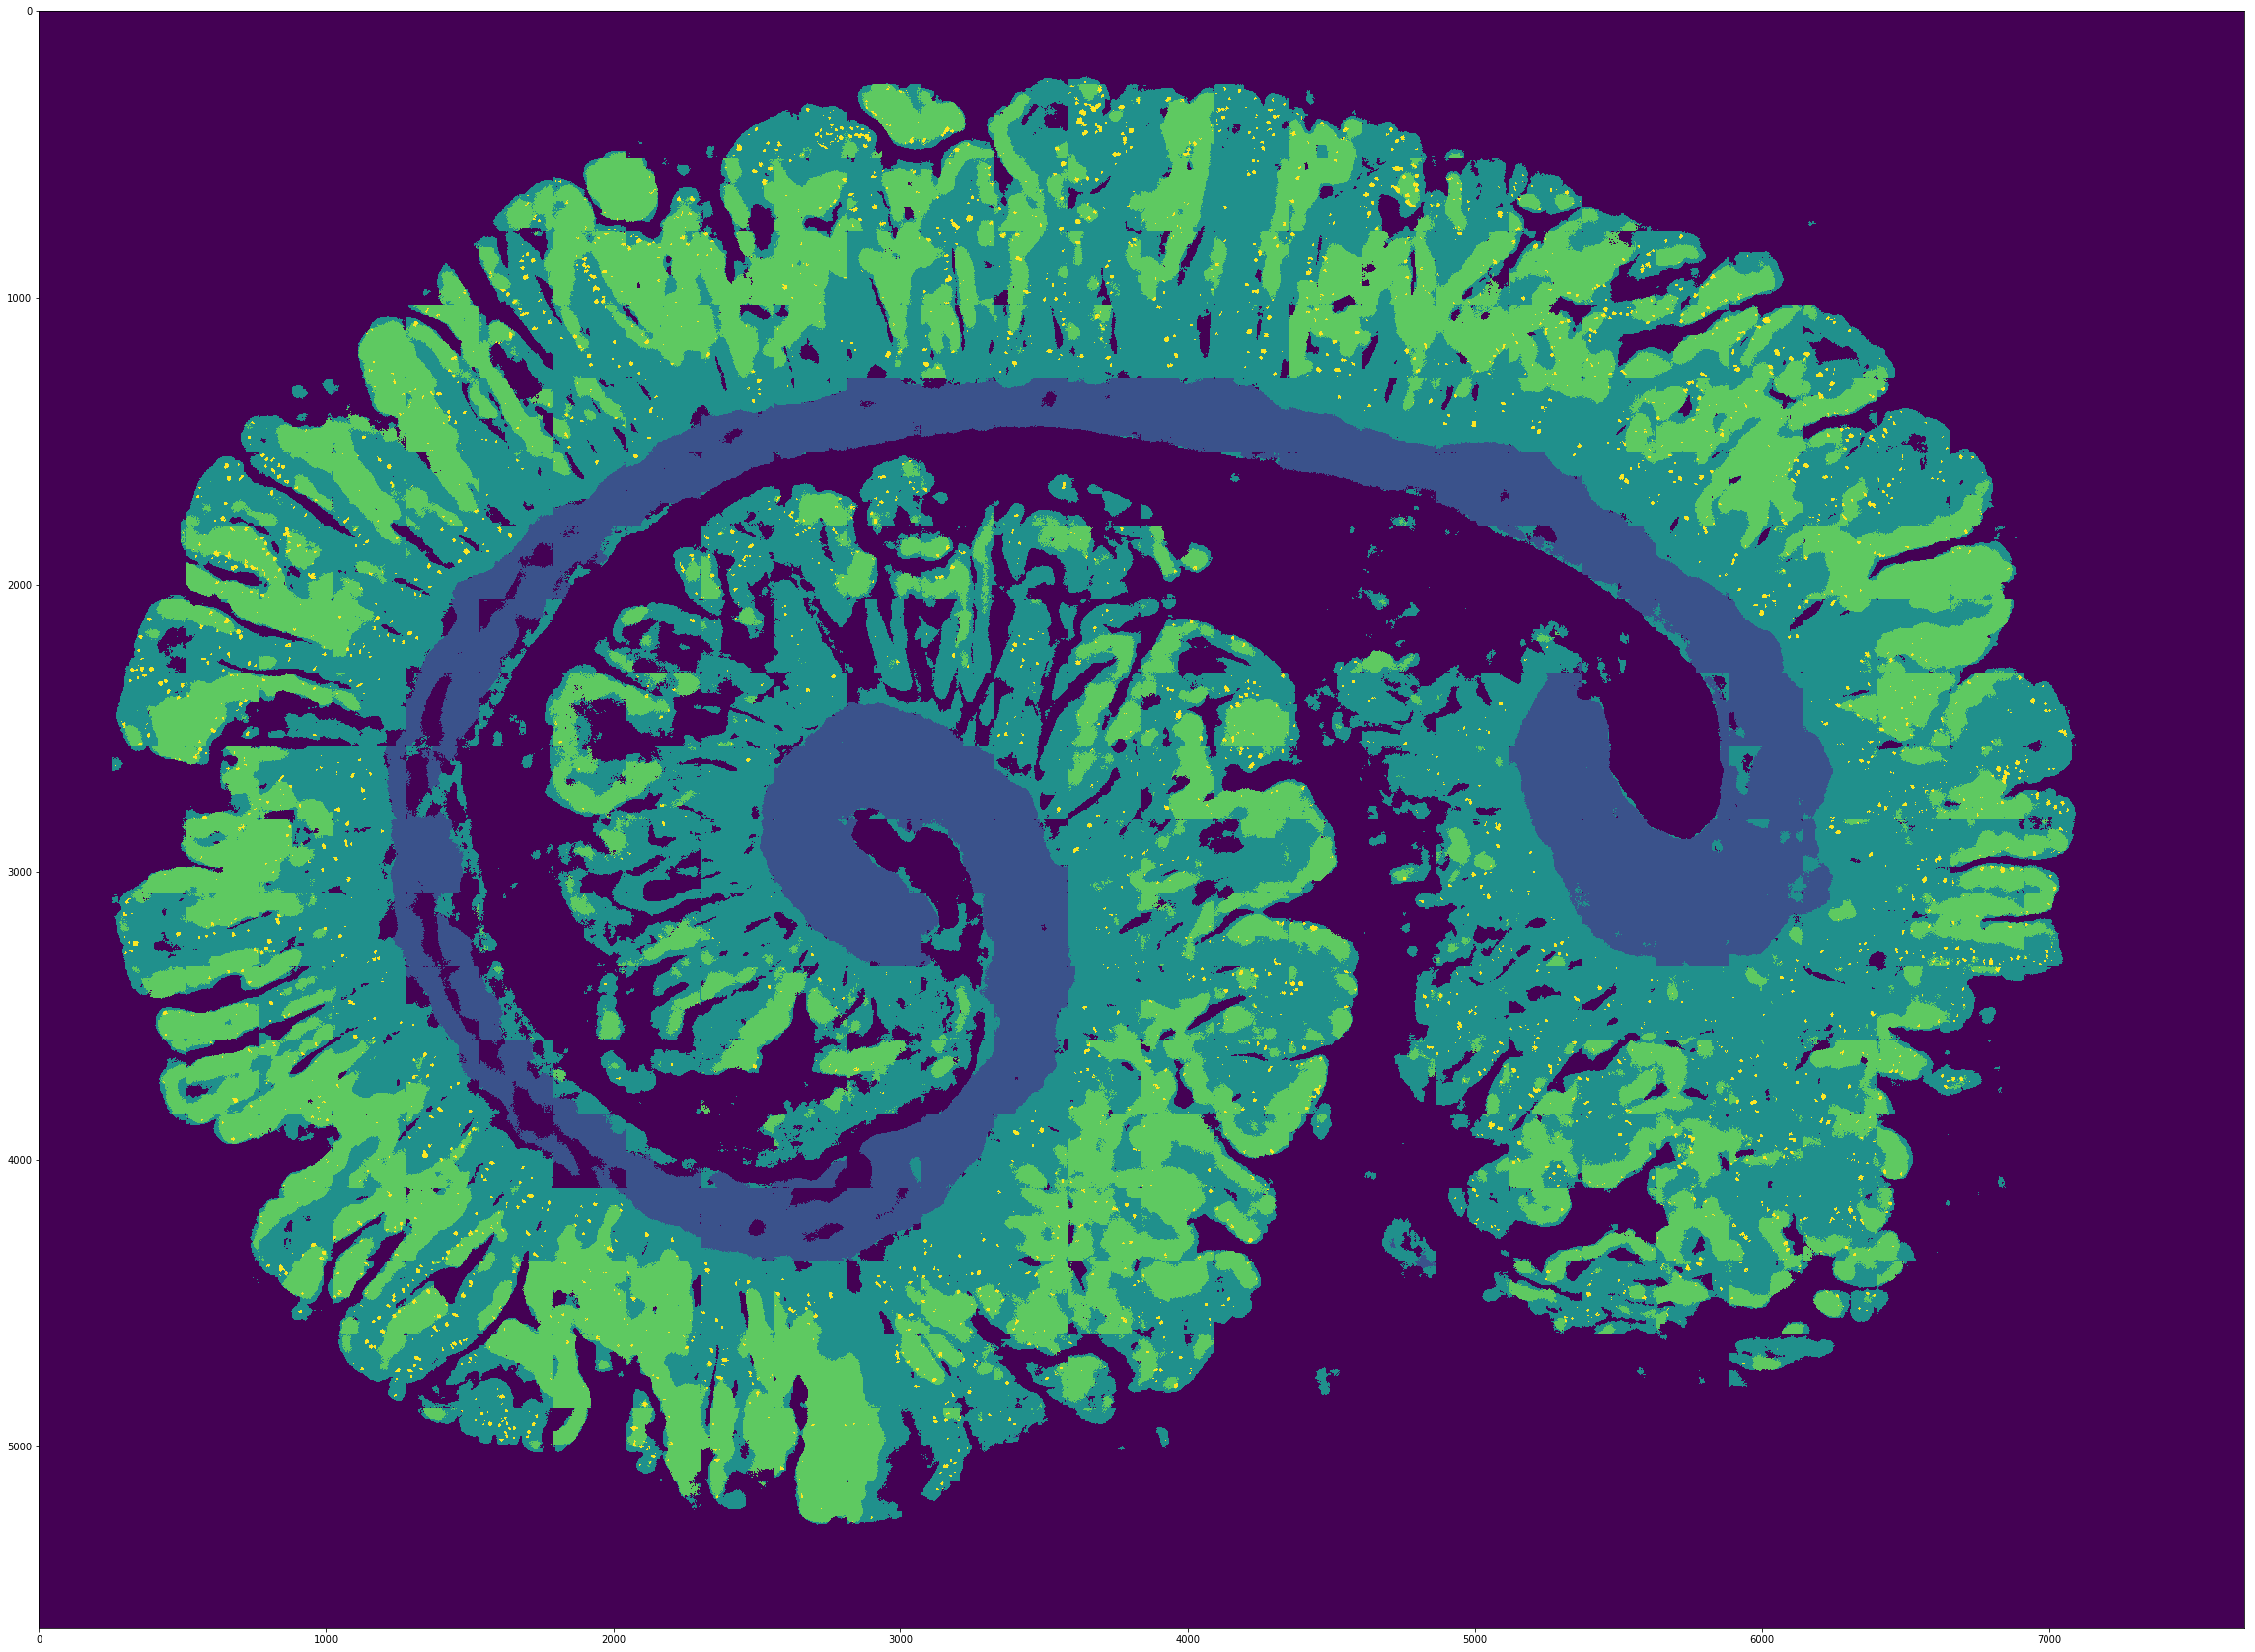

In [159]:
import numpy as np
from numpy import histogram
from numpy import frombuffer, uint32, uint8,float32, squeeze
from matplotlib.pyplot import imshow, figure
from PIL import Image
figure(figsize=(40,40))
#imsave(base+'/../00-mask_2.tif',im.astype(np.uint8))
pim = Image.fromarray(im.astype(np.uint8), mode='P')
pim.save(base+'/test-392_2.tif')

imshow(im.astype(np.uint8))

In [ ]:
import tools
from importlib import reload
from matplotlib.pyplot import imshow, figure
from functools import reduce
ori=Vips.Image.new_from_file(base+'/00-orig.tif')
da=tools.resize_indexed(Vips.Image.new_from_file(base+'/00-mask_4.tif'),ori.width,ori.height)
da.write_to_file(base+'/00-mask_5.tif')
da2=tools.vips_to_np(da)
figure(figsize=(40,40))
imshow(da2[:,:,0])

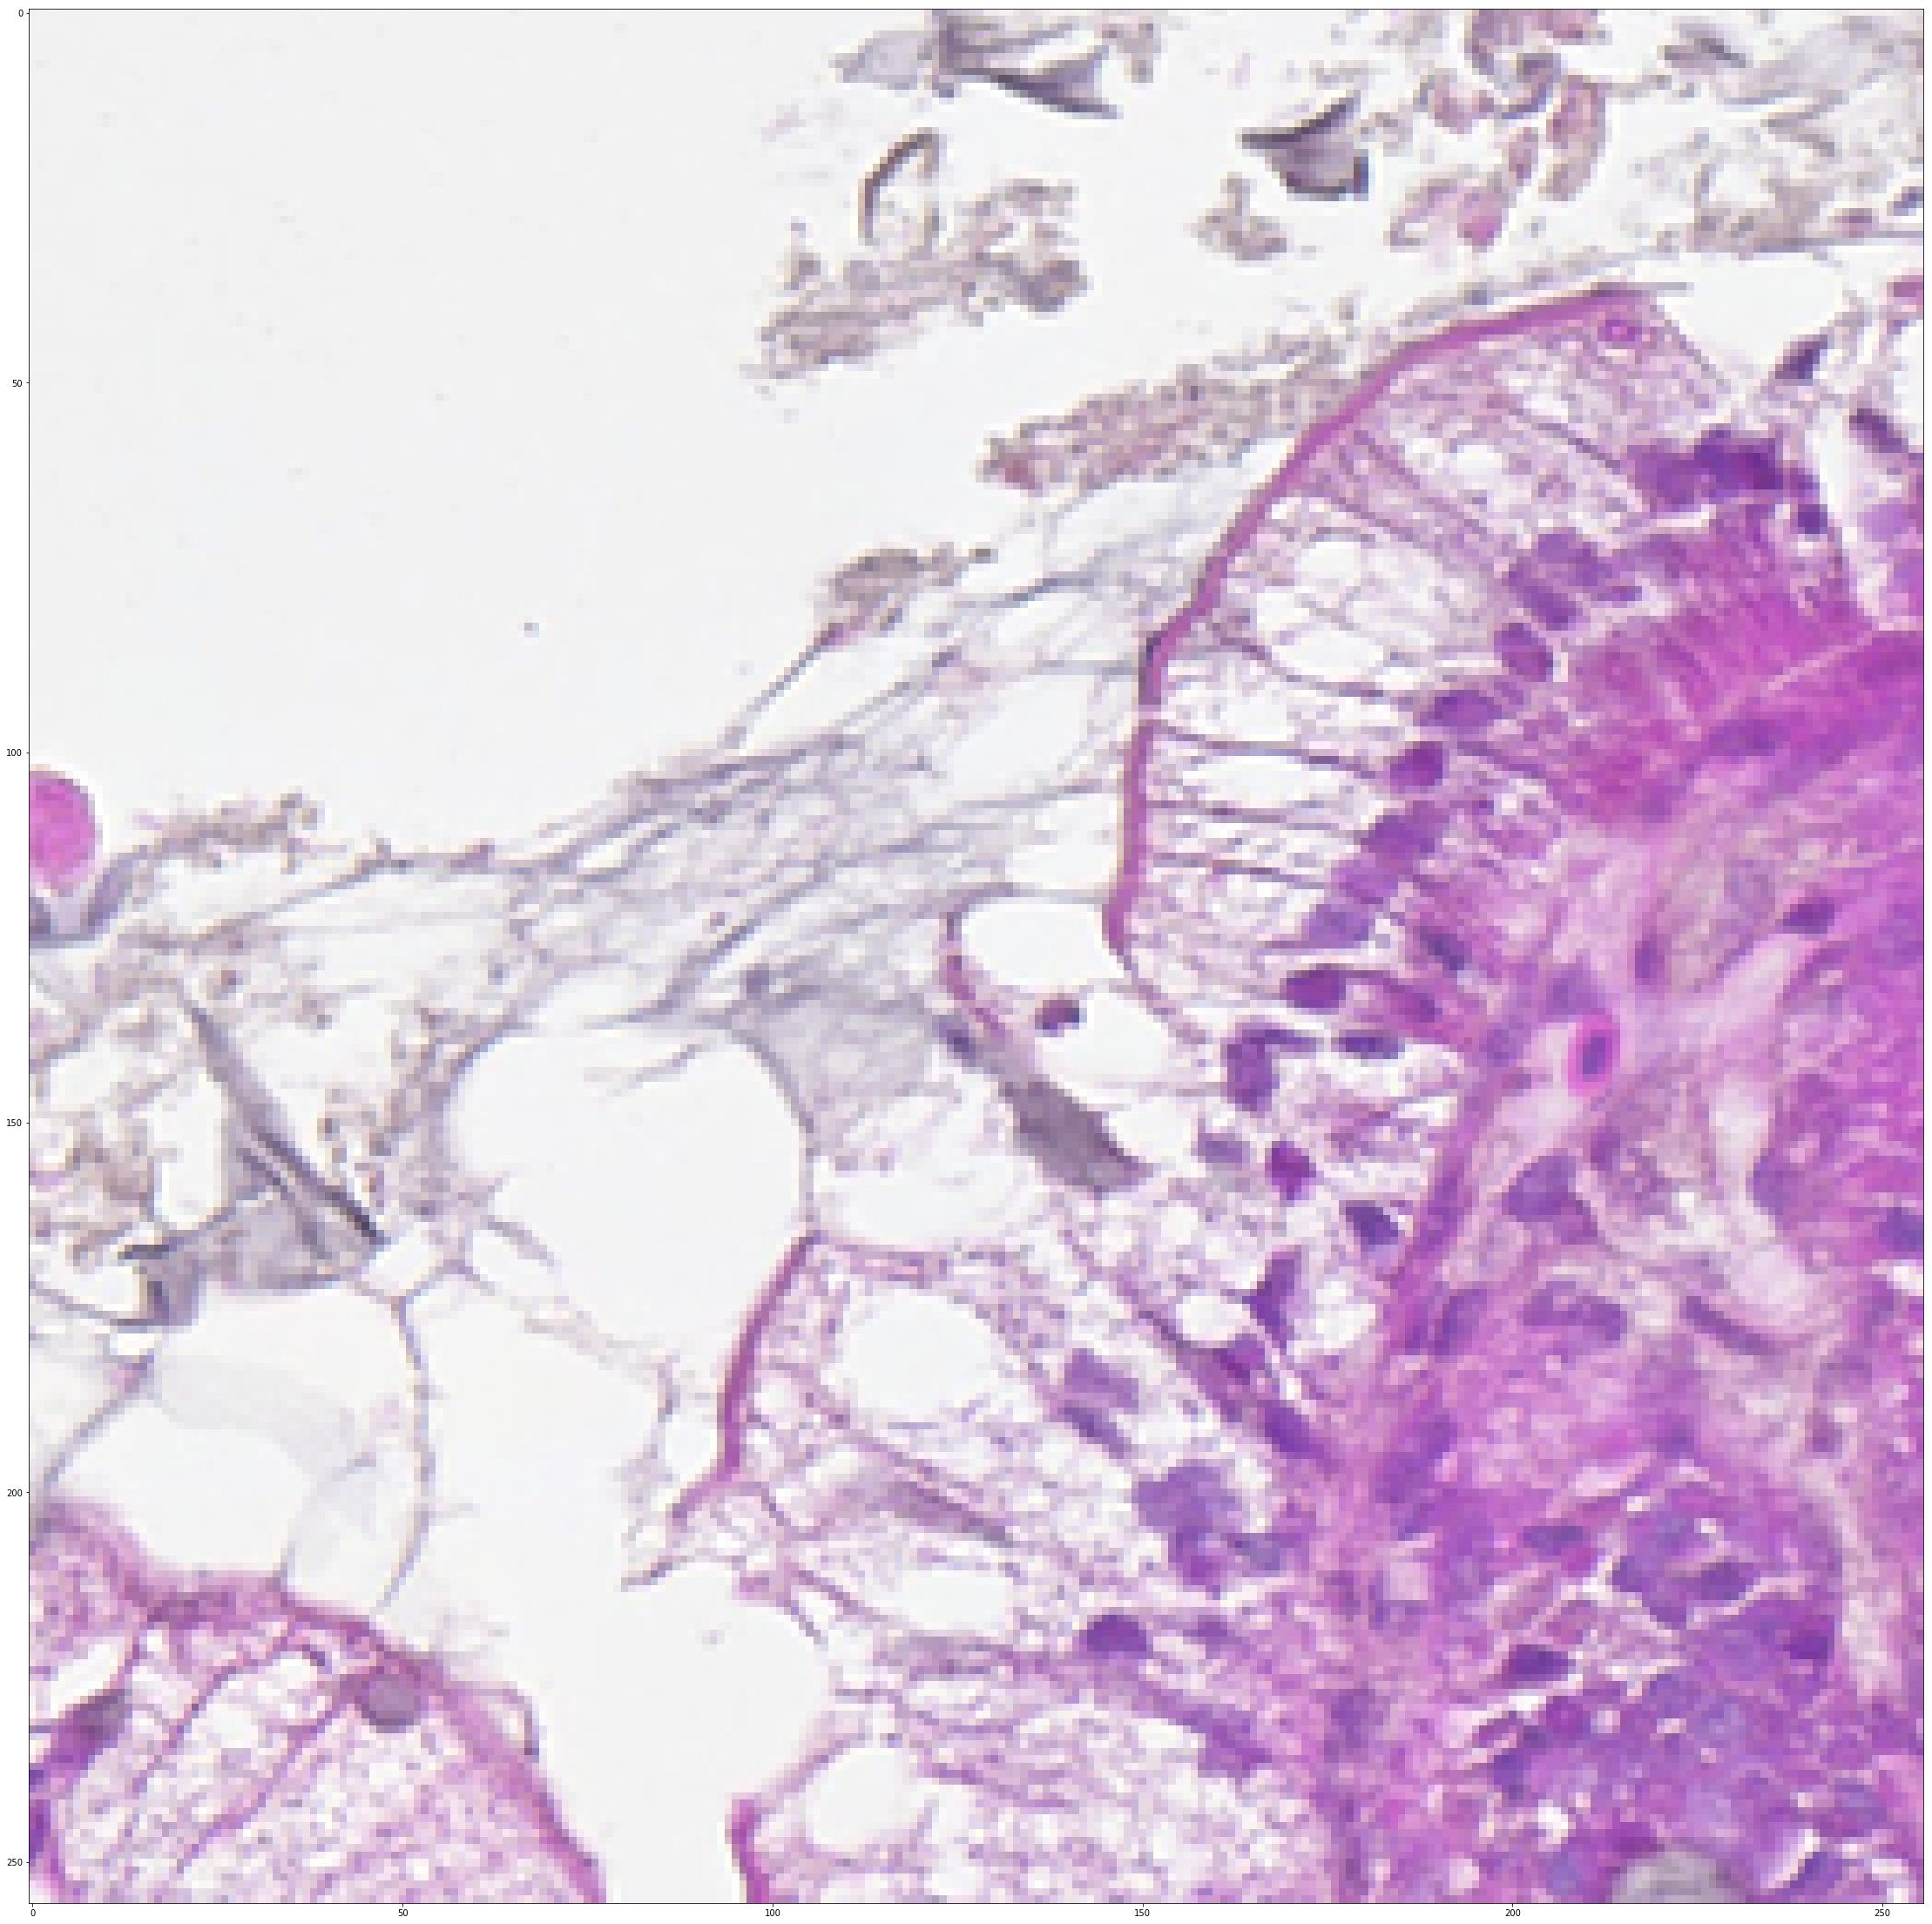

In [136]:

from importlib import reload
reload(VipsML)
reload(tools)
m=VipsML.VipsML(Vips.Image.new_from_file(base+'/00-orig.tif'),Vips.Image.new_from_file(base+'/00-mask.tif'),frame_size=256,padding=0,overlap=0,outer_pad=['white','black'])
a=m.image.get(30)
tools.show_np_im(a)